In [1]:
import pandas as pd
import time
import matplotlib.pyplot as plt
import numpy as np
import opendp.prelude as dp
dp.enable_features("contrib")
dp.enable_features("floating-point")

/Users/Ava/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/Ava/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


# County Level

In [2]:
agg_county_data_df = pd.read_csv("/Users/Ava/Library/CloudStorage/OneDrive-Personal/Thesis/Code/agg_commute_county_level_all.csv")
county_data_df = pd.read_csv("/Users/Ava/Library/CloudStorage/OneDrive-Personal/Thesis/Code/commute_county_level_all.csv")

In [3]:
county_categories = agg_county_data_df['County_commute'].unique()
len(county_categories) # MUST TAKE FROM DATA WHERE CATEGORIES CAN HAVE COUNT 0 ie.not where each individual is row

1085

In [4]:
col_names = ["County_commute","County_Origin","County_Destination"]
size = len(county_data_df) #Number of individuals in dataset
county_categories = list(county_categories) #Number of possible categories 


In [5]:
with open('commute_county_level_all.csv') as input_data:
    county_data = input_data.read()

In [21]:
def plot_histogram(sensitive_counts, released_counts):
    """Plot a histogram that compares true data against released data"""
    import matplotlib.pyplot as plt
    import matplotlib.ticker as ticker

    fig = plt.figure()
    ax = fig.add_axes([1,1,1,1])
    #plt.ylim([0,20000])
    
    tick_spacing = 1.
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    #plt.xlim(0,1084)
    width = .4

    ax.bar(list([x+width for x in range(0, len(sensitive_counts))]), sensitive_counts, width=width, label='True Value')
    ax.bar(list([x+2*width for x in range(0, len(released_counts))]), released_counts, width=width, label='DP Value')

    ax.legend()
    plt.xticks([])  
    plt.title('Histogram of Counts after Laplace Mechanism for County Level Commute')
    plt.xlabel('Commute')
    plt.ylabel('Count')
    plt.show()

In [22]:
max_influence = 2
budget = np.arange(0.5,5.5, 0.5)

In [23]:
#dp.t means this is a transformation. In OpenDP, transformations are used to  preprocess and aggregate data before chaining with a measurement.
#In the histogram function, the dataset undergoes a transforrmation in which the number of individuals in each category is counted 
#The categories in our dataset is the Commute. 

histogram = (
    dp.t.make_split_dataframe(separator=",", col_names=col_names) >>
    dp.t.make_select_column(key="County_commute", TOA=str) >>
    # Compute counts for each of the categories
    dp.t.then_count_by_categories(categories=county_categories)
)

#This is the dataset without differential privacy. 
county_sensitive_counts = histogram(county_data)




The scale of the Laplace noise added is determined by the sensiitivty and epsilon. 
This is run for different values of epsilon.
The Laplace mechanism is a measurement (dp.m). In OpenDP, a Measurement is a randomized mapping from datasets to outputs of an arbitrary type. 
Every output from measurement is a differentially private release. 

opendp.mod.binary_search_chain(make_chain, d_in, d_out, bounds=None, T=None) https://docs.opendp.org/en/stable/api/python/opendp.mod.html
Searches for the numeric parameter to make_chain that results in a computation that most tightly satisfies d_out when datasets differ 
by at most d_in, then returns the Transformation or Measurement corresponding to said parameter.

make_chain (Callable[[float], M]) – a function that takes a number and returns a Transformation or Measurement
d_in (Any) – how far apart input datasets can be 
d_out (Any) – how far apart output datasets or distributions can be

https://docs.opendp.org/en/stable/user/measurements/additive-noise-mechanisms.html

https://docs.opendp.org/en/stable/api/python/opendp.measurements.html#opendp.measurements.then_laplace


In [24]:
# empty lists
all_county_released_counts = []
all_county_elapsed_time = []

for epsilon in budget:
    #d_in is the sensistivity 
    #d_out is the privacy budget ie.epsilon
    # noisy_histogram = dp.binary_search_chain(
    #     lambda s: histogram >> dp.m.then_laplace(scale=s),
    #     d_in=max_influence, d_out=epsilon)

    noisy_histogram = histogram >> dp.m.then_base_discrete_laplace(scale = max_influence/epsilon)

    start_time = time.time()
    released_counts = noisy_histogram(county_data)
    end_time = time.time()

    elapsed_time = end_time - start_time
    all_county_elapsed_time.append(elapsed_time)

    # Post-processing to ensure non-negative counts
    released_counts = [max(count, 0) for count in released_counts]
    all_county_released_counts.append(released_counts)

In [25]:
print("Commute level counts:\n", county_sensitive_counts[:-1])
print("DP Commute level counts:\n", all_county_released_counts[0][:-1])

print("DP estimate for the number of records that were not a member of the category set:", released_counts[-1])

Commute level counts:
 [19174, 962, 548, 132, 290, 1251, 1512, 984, 28, 12, 958, 1054, 40, 39, 9, 76, 248, 46, 12, 9, 8, 1978, 6, 1626, 52, 14, 13, 17, 3, 28, 3, 8, 6, 1, 0, 92, 218860, 15302, 22668, 19235, 3056, 41, 71, 1141, 60, 50, 796, 113, 108, 31, 140, 58, 139, 47, 32, 34, 17955, 177, 6548, 62, 369, 53, 142, 26, 518, 35, 31, 32, 33, 8, 84, 44145, 80723, 5199, 12769, 4526, 36, 57, 563, 30, 35, 818, 49, 73, 25, 67, 41, 68, 26, 18, 26, 10631, 61, 2914, 72, 125, 20, 127, 9, 172, 18, 23, 27, 16, 9, 54, 56998, 5941, 91167, 4872, 2236, 22, 29, 3470, 36, 35, 273, 47, 82, 18, 95, 43, 72, 33, 38, 59, 10995, 124, 4410, 36, 1025, 39, 124, 10, 220, 17, 32, 27, 16, 1, 45, 41779, 6154, 2150, 66937, 974, 25, 28, 233, 17, 58, 2979, 54, 62, 12, 72, 25, 84, 26, 15, 16, 6420, 69, 4835, 25, 93, 12, 62, 8, 240, 15, 9, 10, 10, 3, 1701, 18313, 11759, 3645, 3572, 80682, 320, 906, 1285, 973, 57, 1293, 71, 111, 30, 203, 135, 185, 37, 17, 30, 8673, 60, 4465, 120, 87, 21, 336, 27, 176, 34, 37, 41, 27, 4, 163

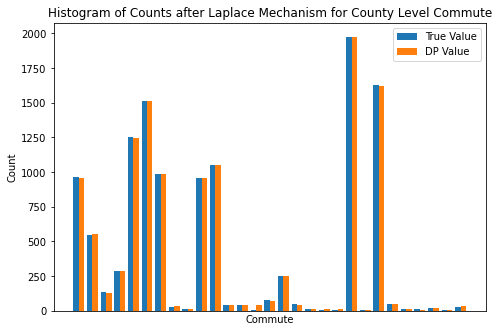

<Figure size 432x288 with 0 Axes>

In [88]:
plot_histogram(county_sensitive_counts[1:30], all_county_released_counts[0][1:30])
plt.savefig("Histogram of Counts after Laplace Mechanism")
plt.show()


In [27]:
def calculate_rmse(predicted_values, actual_values):    
    # Calculate the squared differences
    squared_diffs = np.square(np.array(predicted_values) - np.array(actual_values))
    
    # Calculate the mean of squared differences
    mean_squared_diff = np.mean(squared_diffs)
    
    # Take the square root to get RMSE
    rmse = np.sqrt(mean_squared_diff)
    
    return rmse


In [28]:
all_county_rmse  =[]
for released_count in range(len(budget)):
    rmse = calculate_rmse(all_county_released_counts[released_count], county_sensitive_counts)
    all_county_rmse.append(rmse)


In [29]:
all_county_rmse
budget

array([0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ])

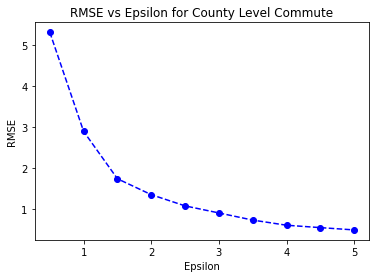

In [86]:
plt.plot(budget, all_county_rmse, 'bo')
plt.plot(budget, all_county_rmse, 'b--')
plt.xlabel('Epsilon')
plt.ylabel('RMSE')  
plt.title('RMSE vs Epsilon for County Level Commute')
plt.savefig('RMSE vs Epsilon for County Level Commute')
plt.show()



In [31]:
#Maximum error 
all_county_max_count_difference = []
all_county_max_count_difference_index = []
for released_count in range(len(budget)):
    max_county_count_difference = max(abs(all_county_released_counts[released_count][idx] - county_sensitive_counts[idx]) for idx in range(len(county_sensitive_counts)))
    all_county_max_count_difference.append(max_county_count_difference)
    county_max_count_difference_index = [idx for idx in range(len(county_sensitive_counts)) if abs(all_county_released_counts[released_count][idx] - county_sensitive_counts[idx]) == max_county_count_difference]
    all_county_max_count_difference_index.append(county_max_count_difference_index)


In [32]:
all_county_max_count_difference
#[28, 14, 8, 7, 6, 6, 4, 3, 3, 3]
all_county_max_count_difference_index
# [[601],
#  [555],
#  [194, 522, 572],
#  [538],
#  [403],
#  [215],
#  [518, 686],
#  [112, 124, 258, 415, 592, 1050],
#  [933],
#  [716]]

[[14],
 [635],
 [283],
 [328],
 [80, 86, 826],
 [177],
 [172, 212, 226, 292, 310, 353, 692, 717, 949, 964],
 [239, 608, 661, 966, 1053],
 [168, 986],
 [26,
  40,
  48,
  180,
  201,
  349,
  390,
  400,
  456,
  470,
  537,
  548,
  626,
  629,
  716,
  718,
  830,
  934,
  954,
  962,
  1060]]

In [33]:
county_mean_time  = np.mean(all_county_elapsed_time)
county_mean_time # in seconds 
#5.557075667381286

4.28439610004425

In [34]:
all_county_elapsed_time

#[5.961507081985474,
#  5.719324111938477,
#  5.47859001159668,
#  5.477495193481445,
#  5.45618200302124,
#  5.492994785308838,
#  5.506938695907593,
#  5.485191106796265,
#  5.466466903686523,
#  5.526066780090332]

[4.133731842041016,
 4.319715976715088,
 4.25703239440918,
 4.283262014389038,
 4.771899938583374,
 4.219617605209351,
 4.225127220153809,
 4.2129058837890625,
 4.193972110748291,
 4.226696014404297]

# ED Level

In [39]:
agg_ed_data_df = pd.read_csv("/Users/Ava/Library/CloudStorage/OneDrive-Personal/Thesis/Code/agg_commute_ed_level_all.csv")
ed_data_df = pd.read_csv("/Users/Ava/Library/CloudStorage/OneDrive-Personal/Thesis/Code/commute_ed_level_all.csv")

In [40]:
ed_categories = agg_ed_data_df['ED_Commute'].unique()
len(ed_categories) # MUST TAKE FROM DATA WHERE CATEGORIES CAN HAVE COUNT 0 ie.not where each individual is row

8699658

In [41]:
col_names = ["ED_commute","ED_Origin","ED_Destination"]
size = len(ed_data_df) #Number of individuals in dataset
ed_categories = list(ed_categories) #Number of possible categories 

In [42]:
with open('commute_ed_level_all.csv') as input_data:
    ed_data = input_data.read()

In [43]:
len(budget)

10

In [44]:
histogram = (
    dp.t.make_split_dataframe(separator=",", col_names=col_names) >>
    dp.t.make_select_column(key="ED_commute", TOA=str) >>
    # Compute counts for each of the categories
    dp.t.then_count_by_categories(categories=ed_categories)
)

ed_sensitive_counts = histogram(ed_data)

# empty dictionary
all_ed_released_counts = []
all_ed_elapsed_time = []

for i, epsilon in enumerate(budget):
    #d_in is the sensistivity 
    #d_out is the privacy budget ie.epsilon
    #noisy_histogram = dp.binary_search_chain(
    #    lambda s: histogram >> dp.m.then_laplace(scale=s),
    #    d_in=max_influence, d_out=epsilon)
    
    noisy_histogram = histogram >> dp.m.then_base_discrete_laplace(scale = max_influence/epsilon)


    start_time = time.time()
    released_counts = noisy_histogram(ed_data)
    end_time = time.time()

    elapsed_time = end_time - start_time
    all_ed_elapsed_time.append(elapsed_time)

    # Post-processing to ensure non-negative counts
    released_counts = [max(count, 0) for count in released_counts]
    all_ed_released_counts.append(released_counts)
    print(f'{(i+1)/len(budget)} Completed.', end = '\r')

In [46]:
all_ed_rmse  =[]
for released_count in range(len(budget)):
    rmse = calculate_rmse(all_ed_released_counts[released_count], ed_sensitive_counts)
    all_ed_rmse.append(rmse)


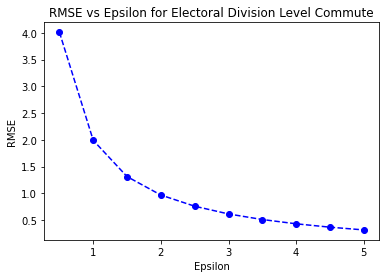

In [85]:
plt.plot(budget, all_ed_rmse, 'bo')
plt.plot(budget, all_ed_rmse, 'b--')
plt.xlabel('Epsilon')
plt.ylabel('RMSE')  
plt.title('RMSE vs Epsilon for Electoral Division Level Commute')
plt.savefig("RMSE vs Epsilon for Electoral Division Level Commute")
plt.show()


In [69]:
all_ed_released_counts
np.save('ED_noisy_counts', np.array(all_ed_released_counts))

In [48]:
#Maximum error 
all_ed_max_count_difference = []
all_ed_max_count_difference_index = []
for released_count in range(len(budget)):
    max_ed_count_difference = max(abs(all_ed_released_counts[released_count][idx] - ed_sensitive_counts[idx]) for idx in range(len(ed_sensitive_counts)))
    all_ed_max_count_difference.append(max_ed_count_difference)
    ed_max_count_difference_index = [idx for idx in range(len(ed_sensitive_counts)) if abs(all_ed_released_counts[released_count][idx] - ed_sensitive_counts[idx]) == max_ed_count_difference]
    all_ed_max_count_difference_index.append(ed_max_count_difference_index)


In [61]:
all_ed_max_count_difference
#[68, 29, 20, 14, 12, 11, 8, 8, 6, 5]
all_ed_max_count_difference_index
# [[3995347],
#  [2948904, 4902328],
#  [5386754, 7856045],
#  [1253085, 4099484, 5330020, 5424901, 6083347, 6195908],
#  [83990, 6391516],
#  [8622047],
#  [250244, 2249811, 4384774, 7331521, 7922723, 8190196],
#  [1382390],
#  [31922,
#   251657,
#   1957862,
#   2134769,
#   4618140,
#   5806393,
#   6155596,
#   6558704,
#   7955439,
#   8031965,
#   8047788,
#   8331495,
#   8549123],
#  [191719,
#   594059,
#   915901,
#   1393125,
#   1498081,
#   1701462,
#   1952255,
#   2959362,
#   2994676,
#   3198443,
#   3302997,
#   3377087,
#   3382580,
#   3893761,
#   4154271,
#   4867635,
#   4905555,
#   5215095,
#   5983246,
#   6448484,
#   6631294,
#   6635624,
#   6985572,
#   7134399,
#   7140949,
#   7360758,
#   7474248,
#   8016989,
#   8309350,
#   8377059,
#   8406126]]

[68, 29, 20, 14, 12, 11, 8, 8, 6, 5]

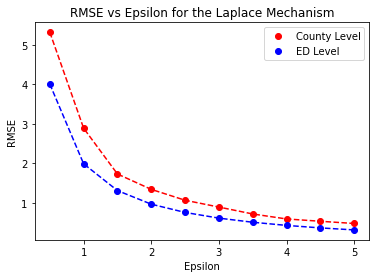

In [83]:
plt.plot(budget, all_county_rmse, 'ro', label='County Level')
plt.plot(budget, all_county_rmse, 'r--')

plt.plot(budget, all_ed_rmse, 'bo', label='ED Level')
plt.plot(budget, all_ed_rmse, 'b--')
plt.xlabel('Epsilon')
plt.ylabel('RMSE')  
plt.title('RMSE vs Epsilon for the Laplace Mechanism')
plt.legend(loc="upper right")
plt.savefig("RMSE vs Epsilon for the Laplace Mechanism")
plt.show()



In [54]:
all_ed_elapsed_time
# [414.3674931526184,|
#  332.5656387805939,
#  333.07225608825684,
#  320.9939818382263,
#  320.56924319267273,
#  333.8113238811493,
#  360.2779760360718,
#  332.6513411998749,
#  335.4997880458832,
#  435.3151710033417]

[338.32745027542114,
 326.20035672187805,
 339.60717606544495,
 335.1741099357605,
 319.80569291114807,
 328.249862909317,
 332.78489780426025,
 320.4517800807953,
 327.55916690826416,
 318.695130109787]

In [55]:
ed_mean_time  = np.mean(all_ed_elapsed_time)
ed_mean_time # in seconds 
#351.9124213218689

328.68556237220764

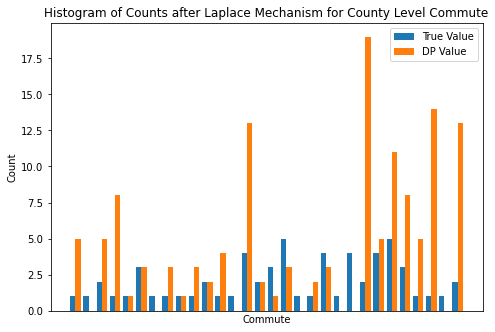

<Figure size 432x288 with 0 Axes>

In [90]:
plot_histogram(ed_sensitive_counts[50:80], all_ed_released_counts[0][50:80])
plt.savefig("Histogram of Counts after Laplace Mechanism for ED")
plt.show()

In [57]:
print(ed_data[100:130])

ban
Carlow Urban-Carlow Urban,


In [74]:
label_df = agg_ed_data_df.loc[agg_ed_data_df['ED_Commute'].isin(ed_categories[50:80])]

In [75]:
label_df

,ED_Commute,Origin_ED,Destination_ED,EDCommute_Count
50,Carlow Urban-Mansion House B,Carlow Urban,Mansion House B,1.0
51,Carlow Urban-Merchants Quay B,Carlow Urban,Merchants Quay B,1.0
52,Carlow Urban-Merchants Quay E,Carlow Urban,Merchants Quay E,2.0
53,Carlow Urban-Pembroke East E,Carlow Urban,Pembroke East E,1.0
54,Carlow Urban-Pembroke West A,Carlow Urban,Pembroke West A,1.0
55,Carlow Urban-Royal Exchange A,Carlow Urban,Royal Exchange A,3.0
56,Carlow Urban-Royal Exchange B,Carlow Urban,Royal Exchange B,1.0
57,Carlow Urban-St. Kevin's,Carlow Urban,St. Kevin's,1.0
58,Carlow Urban-South Dock,Carlow Urban,South Dock,1.0
59,Carlow Urban-Ushers A,Carlow Urban,Ushers A,1.0
